In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [2]:
(train_data, test_data), ds_info = tfds.load("oxford_iiit_pet",
                          split=['train', 'test'],
                          with_info=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD6A4Y4/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD6A4Y4/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpyzydypg8tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [4]:
def resize(input_image, input_mask, IMG_SIZE=128):
  input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE), method='nearest')
  input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')

  return input_image, input_mask

In [5]:
def augment(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, dtype=tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

In [7]:
def load_train_image(data):
  input_image = data["image"]
  input_mask = data["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_test_image(data):
  input_image = data['image']
  input_mask = data['segmentation_mask']
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
BATCH_SIZE = 64

train_final_data = train_data.map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
train_final_data = train_final_data.cache().shuffle(buffer_size=1000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_final_data = test_data.map(load_test_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_final_data = test_final_data.take(3000).batch(batch_size=BATCH_SIZE)
test_final_data = test_final_data.skip(3000).take(669).batch(batch_size=BATCH_SIZE)

In [9]:
import matplotlib.pyplot as plt
import random

In [10]:
image, mask = next(iter(train_final_data))

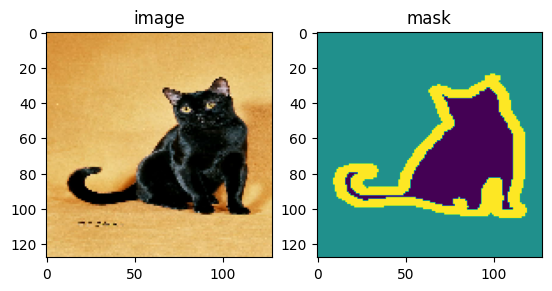

In [11]:
index = random.randint(0, len(image))-1
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[index])
plt.subplot(1, 2, 2)
plt.title('mask')
plt.imshow(mask[index])

In [12]:
def double_conv_block(x, n_filters):
  x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation='relu')(x)
  x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu')(x)
  return x

In [13]:
def downsample_block(x, n_filters):
  x = double_conv_block(x, n_filters)
  p = tf.keras.layers.MaxPool2D()(x)
  p = tf.keras.layers.Dropout(0.3)(p)
  return x, p

In [14]:
def upsample_block(x, conv_features, n_filters):
  x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
  x = tf.keras.layers.concatenate([x, conv_features])
  x = tf.keras.layers.Dropout(0.3)(x)
  x = double_conv_block(x, n_filters)

  return x

In [15]:
inputs = tf.keras.layers.Input(shape=(128, 128, 3))

f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

bottleneck = double_conv_block(p4, 1024)

u1 = upsample_block(bottleneck, f4, 512)
u2 = upsample_block(u1, f3, 256)
u3 = upsample_block(u2, f2, 128)
u4 = upsample_block(u3, f1, 64)

outputs = tf.keras.layers.Conv2D(3, 1, padding='same', activation='softmax')(u4)

unet_model = tf.keras.Model(inputs, outputs)

unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

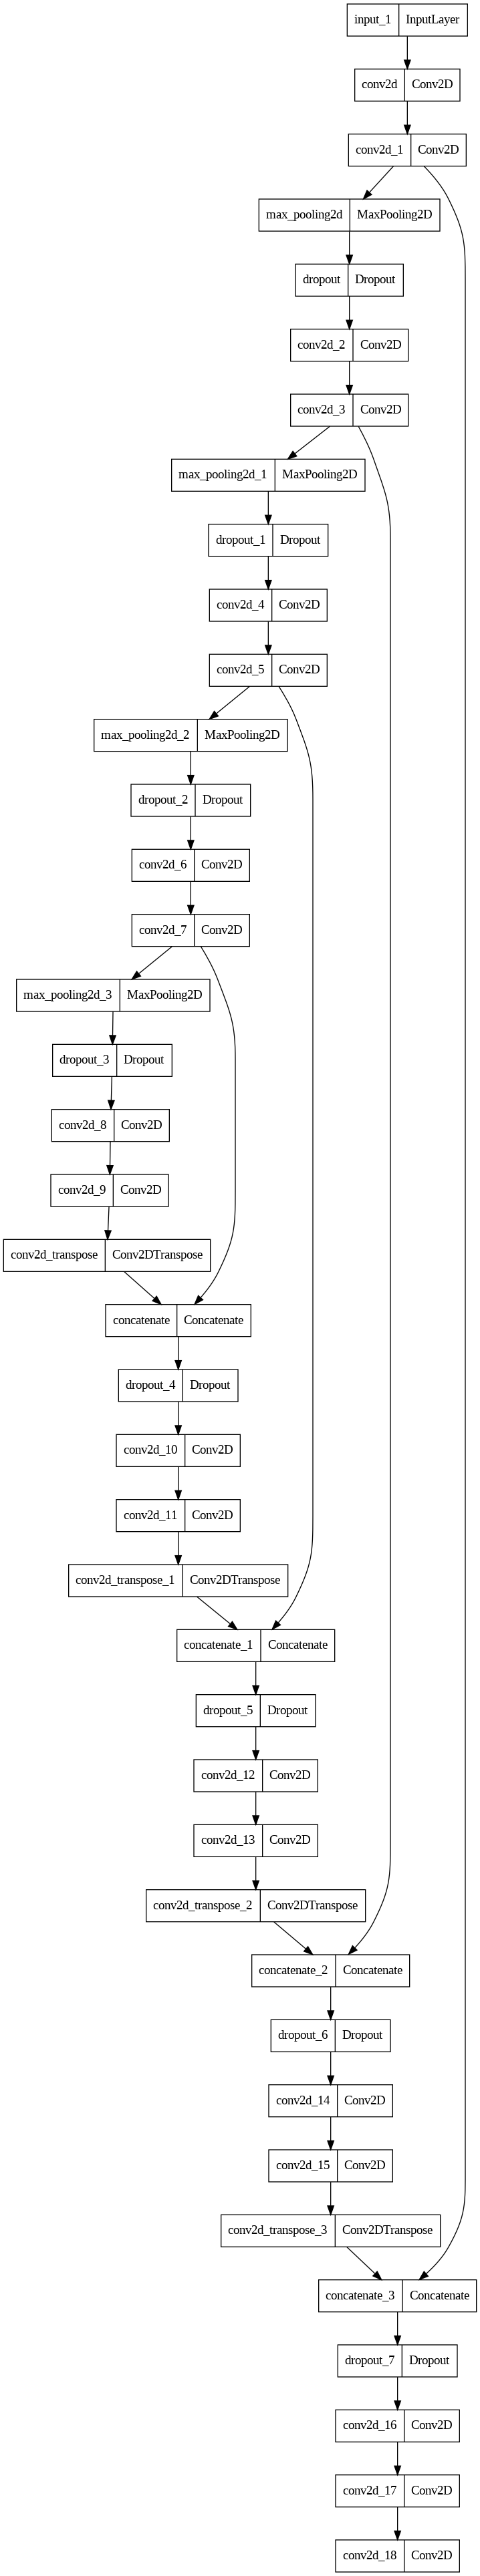

In [16]:
tf.keras.utils.plot_model(unet_model)


In [17]:
unet_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

In [19]:
history = unet_model.fit(train_final_data,
                         epochs=20,
                         steps_per_epoch = len(train_final_data),
                         validation_data = validation_final_data,
                         validation_steps = len(validation_final_data))

Epoch 1/20
58/58 [==============================] - 155s 2s/step - loss: 0.9373 - accuracy: 0.5785 - val_loss: 0.9031 - val_accuracy: 0.5752
Epoch 2/20
58/58 [==============================] - 65s 1s/step - loss: 0.7966 - accuracy: 0.6531 - val_loss: 0.7230 - val_accuracy: 0.7129
Epoch 3/20
58/58 [==============================] - 65s 1s/step - loss: 0.6955 - accuracy: 0.7171 - val_loss: 0.6796 - val_accuracy: 0.7197
Epoch 4/20
58/58 [==============================] - 65s 1s/step - loss: 0.6671 - accuracy: 0.7261 - val_loss: 0.6527 - val_accuracy: 0.7303
Epoch 5/20
58/58 [==============================] - 74s 1s/step - loss: 0.6354 - accuracy: 0.7400 - val_loss: 0.6426 - val_accuracy: 0.7386
Epoch 6/20
58/58 [==============================] - 66s 1s/step - loss: 0.6128 - accuracy: 0.7508 - val_loss: 0.5872 - val_accuracy: 0.7605
Epoch 7/20
58/58 [==============================] - 66s 1s/step - loss: 0.5726 - accuracy: 0.7704 - val_loss: 0.5795 - val_accuracy: 0.7761
Epoch 8/20
58/58 [=

In [20]:
result = unet_model.evaluate(test_final_data)

11/11 [==============================] - 19s 905ms/step - loss: 0.3394 - accuracy: 0.8739
